# COMP90084 Workshop Week 8
In this week's workshop, we will implement the two algorithms, qPCA and quantum enhanced SVM, which were discussed during last week's lectures.
## qPCA

In [2]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import DensityMatrix, partial_trace, Statevector
import sympy as sym
from sklearn import datasets

Load the Iris dataset directly from scikit-learn and calculate the covariance matrix with numpy

In [5]:
iris = datasets.load_iris()
# only look at column 1 and 4
x = np.array(iris.data[:,0])
y = np.array(iris.data[:,3])
print(x[1], y[1])
print(x.shape, y.shape)
# standardise the data
# x = x - np.mean(x)
# y = y - np.mean(y)

print(x[1], y[1])
print(x.shape, y.shape)

iris_data_cov_mat = np.cov(x, y)
print(iris_data_cov_mat)
print(np.trace(iris_data_cov_mat))
# normalize the covariance matrix
iris_data_cov_density_mat = iris_data_cov_mat/np.trace(iris_data_cov_mat)
print(iris_data_cov_density_mat)

4.9 0.2
(150,) (150,)
4.9 0.2
(150,) (150,)
[[0.68569351 0.51627069]
 [0.51627069 0.58100626]]
1.266699776286353
[[0.54132283 0.40757147]
 [0.40757147 0.45867717]]


Load the covariance matrix into the quantum circuit

Calculate $\theta_1$ and $\theta_2$:
$$
\rho = \left[\begin{array}{cc}
\frac{1}{2}\left(1+\operatorname{Cos}\left(\theta_{1}\right) \operatorname{Cos}\left(\theta_{2}\right)\right) & -\frac{1}{2} \operatorname{Cos}\left(\theta_{1}\right) \operatorname{Sin}\left(\theta_{2}\right) \\
-\frac{1}{2} \operatorname{Cos}\left(\theta_{1}\right) \operatorname{Sin}\left(\theta_{2}\right) & \frac{1}{2}\left(1-\operatorname{Cos}\left(\theta_{1}\right) \operatorname{Cos}\left(\theta_{2}\right)\right)
\end{array}\right]
$$

In [3]:
theta1, theta2 = sym.symbols('theta1, theta2')
eq00 = sym.Eq(1/2*(1+sym.cos(theta1)*sym.cos(theta2)), iris_data_cov_density_mat[0,0])
eq01 = sym.Eq(-1/2*sym.cos(theta1)*sym.sin(theta2), iris_data_cov_density_mat[0,1])
eq10 = sym.Eq(-1/2*sym.cos(theta1)*sym.sin(theta2), iris_data_cov_density_mat[1,0])
eq11 = sym.Eq(1/2*(1-sym.cos(theta1)*sym.cos(theta2)), iris_data_cov_density_mat[1,1])
result = sym.solve([eq00, eq01, eq10, eq11], [theta1, theta2])
result = np.array(result, dtype = np.float64)
print(result)

[[ 0.61056909 -1.46975366]
 [ 5.67261622 -1.46975366]]


Construct the $U_{prep}$ circuit

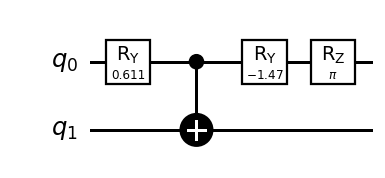

In [4]:
u_prep = QuantumCircuit(2, name='u_prep')
u_prep.ry(result[0,0], 0)
u_prep.cx(0,1)
u_prep.ry(result[0,1], 0)
u_prep.rz(np.pi, 0)
u_prep.draw('mpl', style='bw', scale = 1.5)

Check the partial trace of the state produced by the $U_{prep}$ circuit.

The partial trace is defined as:
$$
\rho=(I \otimes\langle 0|)|\psi\rangle\langle\psi|(I \otimes|0\rangle)+(I \otimes\langle 1|)|\psi\rangle\langle\psi|(I \otimes|1\rangle)
$$
In this case we left the first qubit untouched and traced out the second qubit.

In [5]:
u_prep_rho = DensityMatrix(u_prep)
cov_mat_rho = partial_trace(u_prep_rho, [1]) # trace out the second qubit
print(cov_mat_rho.data)

[[0.54132283+0.000000e+00j 0.40757147+4.991311e-17j]
 [0.40757147-4.991311e-17j 0.45867717+0.000000e+00j]]


In [6]:
print(iris_data_cov_density_mat)

[[0.54132283 0.40757147]
 [0.40757147 0.45867717]]


We can see that the state produced by the $U_{prep}$ circuit (after trace out the second qubit) is indeed the normalized corvariant matrix.

Full qPCA circuit

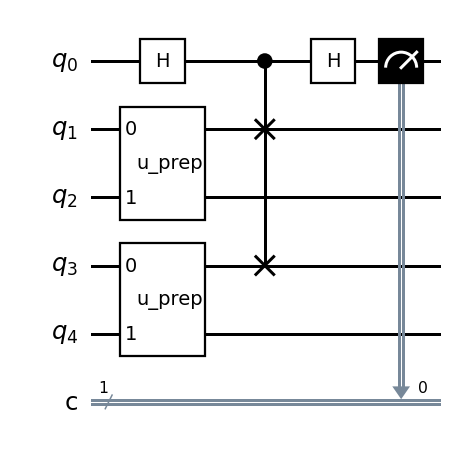

In [7]:
qpca = QuantumCircuit(5,1)
qpca.append(u_prep.to_gate(), [1,2])
qpca.append(u_prep.to_gate(), [3,4])
qpca.h(0)
qpca.cswap(control_qubit=0, target_qubit1=1, target_qubit2=3)
qpca.h(0)
qpca.measure(0,0)
qpca.draw('mpl', style = 'bw', scale=1.5)

In [8]:
# run the simulation
simulator = qiskit.Aer.get_backend('aer_simulator')
qpca = qiskit.transpile(qpca, simulator)
result = simulator.run(qpca, shots = 100000).result()
counts = result.get_counts(qpca)
print(counts)
probs = {}
for key in counts.keys():
    probs[key] = counts[key]/sum(counts.values())
print(probs)

{'1': 8139, '0': 91861}
{'1': 0.08139, '0': 0.91861}


Estimate the eigenvalues

In [9]:
prob_diff = probs['0'] - probs['1']
lambda1 = np.trace(iris_data_cov_mat)*(1+np.sqrt(1-2*(1-prob_diff)))/2
lambda2 = np.trace(iris_data_cov_mat)*(1-np.sqrt(1-2*(1-prob_diff)))/2
print([lambda1, lambda2])

[1.1534840252483596, 0.11321575103799328]


Eigenvalues directly from the covariant matrix:

In [10]:
np.linalg.eigvals(iris_data_cov_mat)

array([1.1522673 , 0.11443247])

Or we can extract the probabilities from the state of the circuit

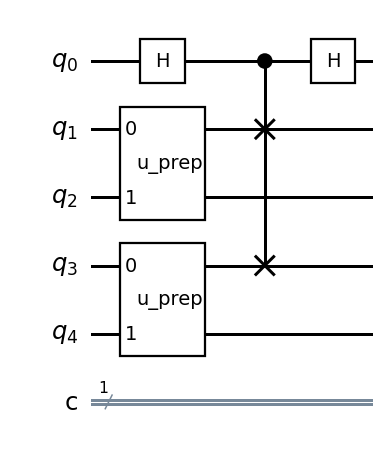

In [11]:
# no measurement at the end, just need the density matrix
qpca_dm = QuantumCircuit(5,1)
qpca_dm.append(u_prep.to_gate(), [1,2])
qpca_dm.append(u_prep.to_gate(), [3,4])
qpca_dm.h(0)
qpca_dm.cswap(control_qubit=0, target_qubit1=1, target_qubit2=3)
qpca_dm.h(0)
qpca_dm.draw('mpl', style = 'bw', scale = 1.5)

In [12]:
# convert to density matrix
final_state = DensityMatrix(qpca_dm)
# trace out the qubits except the first one
final_state_first_qubit = partial_trace(final_state, [1,2,3,4])
final_state_first_qubit.data

array([[0.91782208+4.86297311e-33j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.08217792-4.86297311e-33j]])

In [13]:
# extract the probabilities from the density matrix
probs_dm = final_state_first_qubit.probabilities_dict()
print(probs_dm)

{'0': 0.9178220820842811, '1': 0.08217791791571877}


In [14]:
# estimate the eigenvalues
prob_diff_dm = probs_dm['0'] - probs_dm['1']
lambda1_dm = np.trace(iris_data_cov_mat)*(1+np.sqrt(1-2*(1-prob_diff_dm)))/2
lambda2_dm = np.trace(iris_data_cov_mat)*(1-np.sqrt(1-2*(1-prob_diff_dm)))/2
print([lambda1_dm, lambda2_dm])
print(np.linalg.eigvals(iris_data_cov_mat))

[1.152267303509043, 0.11443247277730993]
[1.1522673  0.11443247]


## Quantum Kernel Machine Learning
This section follows https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html.

The general task of machine learning is to find and study patterns in data. For many datasets, the datapoints are better understood in a higher dimensional feature space, through the use of a kernel function:
$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$
where $k$ is the kernel function, $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs, $f$ is a map from $n$-dimension to $m$-dimension space and $\langle a,b \rangle$ denotes the dot product. When considering finite data, a kernel function can be represented as a matrix: 
$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

In quantum kernel machine learning, a quantum feature map $\phi(\vec{x})$ is used to map a classical feature vector $\vec{x}$ to a quantum Hilbert space, $| \phi(\vec{x})\rangle \langle \phi(\vec{x})|$, such that $K_{ij} = \left| \langle \phi^\dagger(\vec{x}_j)| \phi(\vec{x}_i) \rangle \right|^{2}$. See [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf) for more details.

In this notebook, we use `qiskit` to calculate a kernel matrix using a quantum feature map, then use this kernel matrix in `scikit-learn` classification and clustering algorithms.


In [15]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 42
algorithm_globals.random_seed = seed

For our classification example, we will use the _ad hoc dataset_ as described in [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf), and the `scikit-learn` [support vector machine](https://scikit-learn.org/stable/modules/svm.html) classification (`svc`) algorithm. 

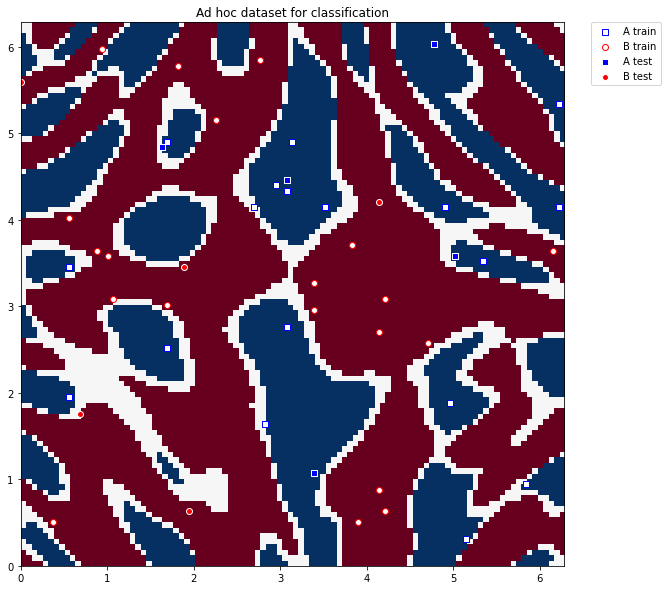

In [16]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.1,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

plt.figure(figsize=(10, 10))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 0), 0],
    test_features[np.where(test_labels[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 1), 0],
    test_features[np.where(test_labels[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

With our training and testing datasets ready, we set up the `QuantumKernel` class to calculate a kernel matrix using the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html), and the `BasicAer` `qasm_simulator` using 1024 shots.

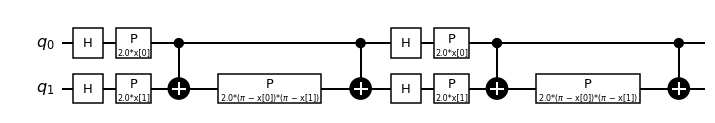

In [17]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

adhoc_backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
)

adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)
adhoc_feature_map.decompose().draw('mpl', style = 'bw')

The `scikit-learn` `svc` algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in `qiskit`.

The following code gives the kernel as a callable function:

In [18]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_features, train_labels)
adhoc_score = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score}")

Callable kernel classification test score: 0.9


The following code precomputes and plots the training and testing kernel matrices before providing them to the `scikit-learn` `svc` algorithm:

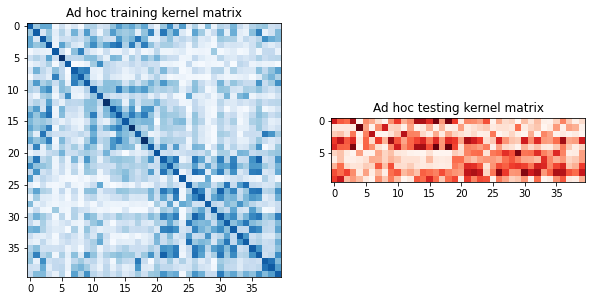

Precomputed kernel classification test score: 0.9


In [19]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()

adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(adhoc_matrix_train, train_labels)
adhoc_score = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score}")

`qiskit` also contains the `qsvc` class that extends the `sklearn svc` class, that can be used as follows:

In [20]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.9


## Training the Quantum Embedding Kernel

Based on https://pennylane.ai/qml/demos/tutorial_kernels_module.html#training-qeks

To be able to train the Quantum Embedding Kernel we need some measure of
how well it fits the dataset in question. Performing an exhaustive
search in parameter space is not a good solution because it is very
resource intensive, and since the accuracy is a discrete quantity we
would not be able to detect small improvements.

We can, however, resort to a more specialized measure, the
*kernel-target alignment*. The kernel-target alignment compares the
similarity predicted by the quantum kernel to the actual labels of the
training data. It is based on *kernel alignment*, a similiarity measure
between two kernels with given kernel matrices $K_1$ and $K_2$:

$$\operatorname{KA}(K_1, K_2) = \frac{\operatorname{Tr}(K_1 K_2)}{\sqrt{\operatorname{Tr}(K_1^2)\operatorname{Tr}(K_2^2)}}.$$



Seen from a more theoretical side, $\operatorname{KA}$ is nothing else
than the cosine of the angle between the kernel matrices $K_1$ and $K_2$
if we see them as vectors in the space of matrices with the
Hilbert-Schmidt (or Frobenius) scalar product
$\langle A, B \rangle = \operatorname{Tr}(A^T B)$. This reinforces the
geometric picture of how this measure relates to objects, namely two
kernels, being aligned in a vector space.


The training data enters the picture by defining an *ideal* kernel
function that expresses the original labelling in the vector
$\boldsymbol{y}$ by assigning to two datapoints the product of the
corresponding labels:

$$k_{\boldsymbol{y}}(\boldsymbol{x}_i, \boldsymbol{x}_j) = y_i y_j.$$

The assigned kernel is thus $+1$ if both datapoints lie in the same
class and $-1$ otherwise and its kernel matrix is simply given by the
outer product $\boldsymbol{y}\boldsymbol{y}^T$. The kernel-target
alignment is then defined as the kernel alignment of the kernel matrix
$K$ generated by the quantum kernel and
$\boldsymbol{y}\boldsymbol{y}^T$:

$$\operatorname{KTA}_{\boldsymbol{y}}(K)
= \frac{\operatorname{Tr}(K \boldsymbol{y}\boldsymbol{y}^T)}{\sqrt{\operatorname{Tr}(K^2)\operatorname{Tr}((\boldsymbol{y}\boldsymbol{y}^T)^2)}}
= \frac{\boldsymbol{y}^T K \boldsymbol{y}}{\sqrt{\operatorname{Tr}(K^2)} N}$$

where $N$ is the number of elements in $\boldsymbol{y}$, that is the
number of datapoints in the dataset.

In summary, the kernel-target alignment effectively captures how well
the kernel you chose reproduces the actual similarities of the data. It
does have one drawback, however: having a high kernel-target alignment
is only a necessary but not a sufficient condition for a good
performance of the kernel. This means having good alignment is
guaranteed for good performance, but optimal alignment will not always
bring optimal training accuracy with it.




In [21]:
from pennylane import numpy as np
np.random.seed(1359)
import pennylane as qml
import matplotlib as mpl
import time

Make a toy data set

In [22]:
def _make_circular_data(num_sectors):
    """Generate datapoints arranged in an even circle."""
    center_indices = np.array(range(0, num_sectors))
    sector_angle = 2 * np.pi / num_sectors
    angles = (center_indices + 0.5) * sector_angle
    x = 0.7 * np.cos(angles)
    y = 0.7 * np.sin(angles)
    labels = 2 * np.remainder(np.floor_divide(angles, sector_angle), 2) - 1

    return x, y, labels


def make_double_cake_data(num_sectors):
    x1, y1, labels1 = _make_circular_data(num_sectors)
    x2, y2, labels2 = _make_circular_data(num_sectors)

    # x and y coordinates of the datapoints
    x = np.hstack([x1, 0.5 * x2])
    y = np.hstack([y1, 0.5 * y2])

    # Canonical form of dataset
    X = np.vstack([x, y]).T

    labels = np.hstack([labels1, -1 * labels2])

    # Canonical form of labels
    Y = labels.astype(int)

    return X, Y

def plot_double_cake_data(X, Y, ax, num_sectors=None):
    """Plot double cake data and corresponding sectors."""
    x, y = X.T
    cmap = mpl.colors.ListedColormap(["#FF0000", "#0000FF"])
    ax.scatter(x, y, c=Y, cmap=cmap, s=25, marker="s")

    if num_sectors is not None:
        sector_angle = 360 / num_sectors
        for i in range(num_sectors):
            color = ["#FF0000", "#0000FF"][(i % 2)]
            other_color = ["#FF0000", "#0000FF"][((i + 1) % 2)]
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    1,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=color,
                    alpha=0.1,
                    width=0.5,
                )
            )
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    0.5,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=other_color,
                    alpha=0.1,
                )
            )
            ax.set_xlim(-1, 1)

    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    ax.axis("off")

    return ax

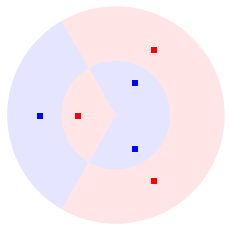

In [23]:
# plot the data
num_sectors = 3
X, Y = make_double_cake_data(num_sectors)

ax = plot_double_cake_data(X, Y, plt.gca(), num_sectors=num_sectors)

Define the circuit for the quantum kernel.

PennyLane\'s [kernels
module](https://pennylane.readthedocs.io/en/latest/code/qml_kernels.html)
allows for a particularly simple implementation of Quantum Embedding
Kernels. The first ingredient we need for this is an *ansatz*, which we
will construct by repeating a layer as building block. Let\'s start by
defining this layer:

In [27]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)
    
dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

init_params = random_params(num_wires=5, num_layers=6)

init_kernel = lambda x1, x2: kernel(x1, x2, init_params)

Let\'s now come back to the actual implementation. PennyLane\'s
`kernels` module allows you to easily evaluate the kernel target
alignment:

In [28]:
kta_init = qml.kernels.target_alignment(X, Y, init_kernel, assume_normalized_kernel=True)

print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

The kernel-target alignment for our dataset and random parameters is 0.088


Now let\'s code up an optimization loop and improve the kernel-target
alignment!

We will make use of regular gradient descent optimization. To speed up
the optimization we will not use the entire training set to compute
$\operatorname{KTA}$ but rather sample smaller subsets of the data at
each step, we choose $4$ datapoints at random. Remember that
PennyLane\'s built-in optimizer works to *minimize* the cost function
that is given to it, which is why we have to multiply the kernel target
alignment by $-1$ to actually *maximize* it in the process.



Note:


Currently, the function `qml.kernels.target_alignment` is not
differentiable yet, making it unfit for gradient descent optimization.
We therefore first define a differentiable version of this function.



In [29]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product


params = init_params
opt = qml.GradientDescentOptimizer(0.5)

for i in range(500):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X))), 4)
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        X[subset],
        Y[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

Step 50 - Alignment = 0.190
Step 100 - Alignment = 0.245
Step 150 - Alignment = 0.267
Step 200 - Alignment = 0.295
Step 250 - Alignment = 0.310
Step 300 - Alignment = 0.326
Step 350 - Alignment = 0.349
Step 400 - Alignment = 0.366
Step 450 - Alignment = 0.372
Step 500 - Alignment = 0.398


We want to assess the impact of training the parameters of the quantum
kernel. Thus, let\'s build a support vector classifier with the
trained kernel:


In [30]:
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y)

We expect to see an accuracy improvement vs. the SVM with random
parameters:


In [32]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

accuracy_trained = accuracy(svm_trained, X, Y)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 1.000


Following on the results that SVM\'s have proven good generalisation
behavior, it will be interesting to inspect the decision boundaries of
our classifier:

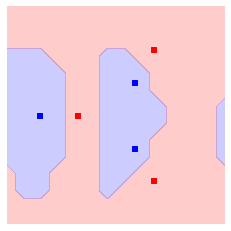

In [33]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1, 1, N_gridpoints), np.linspace(-1, 1, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 1],
    )
    plot_double_cake_data(X, Y, ax)

    return plot_data

trained_plot_data = plot_decision_boundaries(svm_trained, plt.gca())